[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Existing data needs updating - downloading fresh copy

 ndx available data point: 2004-11-18

 ndx last available data point: 2025-04-03

 vix available data point: 2004-11-18

 gld available data point: 2004-11-18

shy available data point: 2004-11-18
Saved fresh data to financial_data.feather


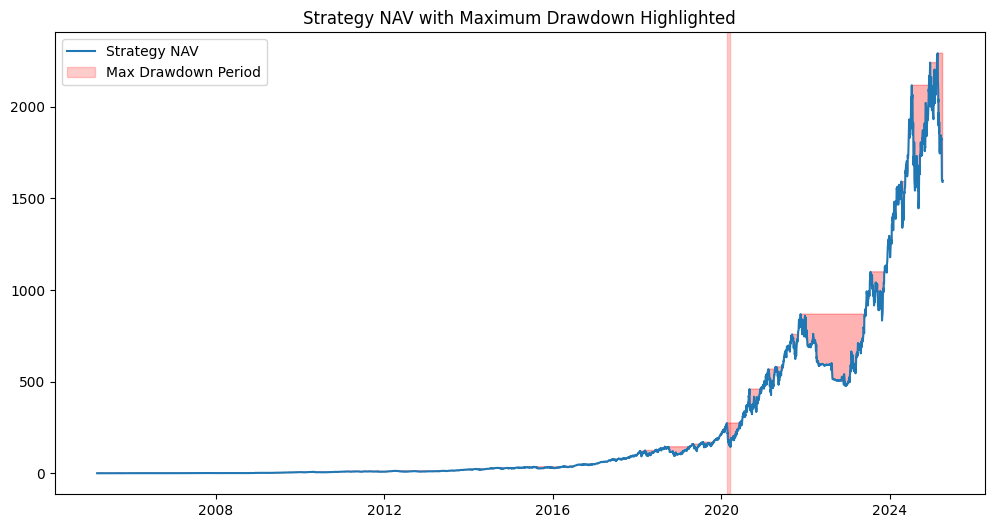

/Users/user/Documents/backtest/analysis.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]
/Users/user/Documents/backtest/analysis.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/Users/user/Documents/backtest/analysis.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_pvalue = model.pvalues[0]


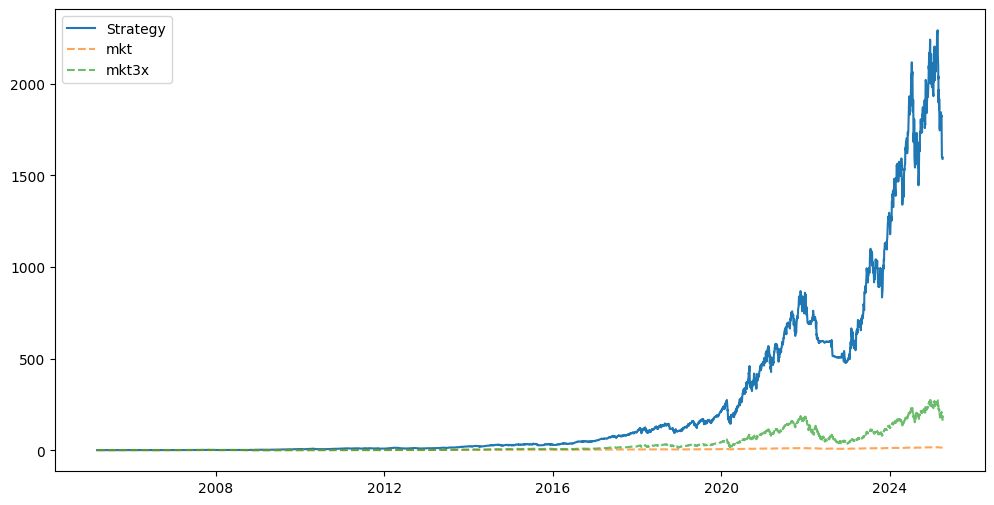


    Strategy Performance Report
    Period: 2005-03-09 to 2025-04-03
    Trading Days: 5051 (20.07 years)
    
    Return Statistics
    -----------------
    Total Return: 160085.23%
    CAGR: 44.44%
    Annualized Volatility: 40.18%
    Win Rate: 55.8%
    
    Risk Metrics
    ------------
    Max Drawdown: -47.41%
    MDD Duration: 30 days, FROM 2020-02-19 00:00:00->2020-03-20 00:00:00
    Sharpe Ratio: 0.99
    Calmar Ratio: 0.94
    
    CAPM Analysis
    -------------
    Alpha_daily: 0.0010 (p-value: 0.0000)
    Alpha annulize: 0.2691)
    Beta: 1.38
    
    Significance Tests
    ------------------
    Strategy Return > risk_free: Confirmed
    (p-value: 0.0000)
    Strategy Return > mkt_daily return: Confirmed
    (p-value: 0.0002)
    Strategy Return > mkt_daily 2x return: Confirmed
    (p-value: 0.0193)
    Strategy Return > mkt_daily 3x return: Rejected
    (p-value: 0.2737)
    


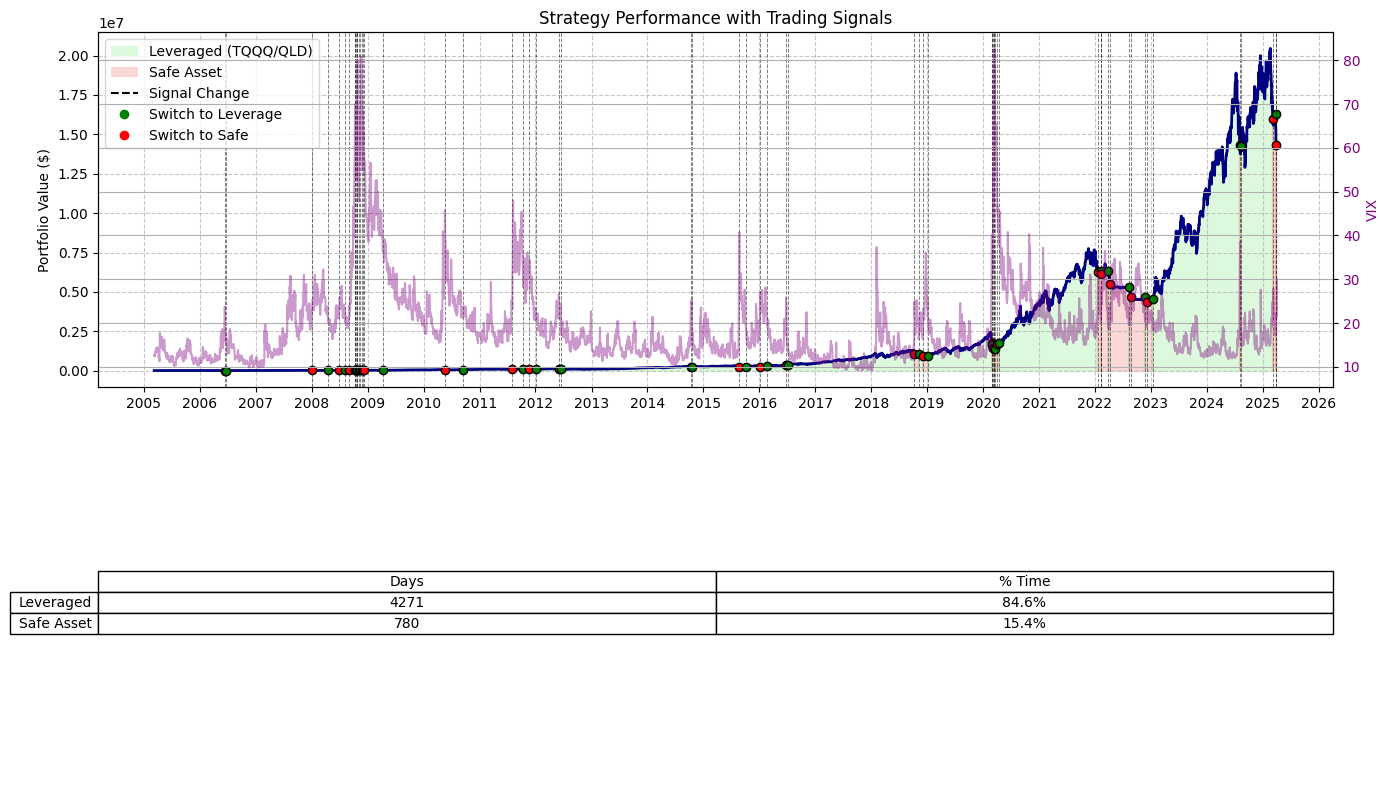

annual turnover: 3.0 

Holding Period Details:
+------------+--------------+------------+-------------------+-------------+-----------+
| Position   | Start Date   | End Date   |   Duration (Days) |   VIX Start |   VIX End |
|------------+--------------+------------+-------------------+-------------+-----------|
| Leverage   | 2005-03-09   | 2006-06-12 |               461 |        12.7 |      21   |
| Safe       | 2006-06-13   | 2006-06-20 |                 8 |        23.8 |      16.7 |
| Leverage   | 2006-06-21   | 2008-01-03 |               562 |        15.5 |      22.5 |
| Safe       | 2008-01-04   | 2008-04-16 |               104 |        23.9 |      20.5 |
| Leverage   | 2008-04-17   | 2008-06-25 |                70 |        20.4 |      21.1 |
| Safe       | 2008-06-26   | 2008-08-05 |                41 |        23.9 |      21.1 |
| Leverage   | 2008-08-06   | 2008-09-03 |                29 |        20.2 |      21.4 |
| Safe       | 2008-09-04   | 2008-10-09 |                36 | 

/Users/user/Documents/backtest/analysis.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Regime_Change'] = df['Signal'].diff().ne(0)
/Users/user/Documents/backtest/analysis.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Regime_Group'] = df['Regime_Change'].cumsum()


In [10]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib
from analysis import *
from download import *
# ====================
# 用戶自定義參數區
# ====================
#START_DATE = "2010-01-01"     # 回測起始日期
START_DATE = "2004-11-18"     # QQQ 上市日
END_DATE = "2025-04-04"       # 回測結束日期
INITIAL_CAPITAL = 10000       # 初始資金
COMMISSION = 0.01            # 單次交易佣金率（0.1%）+ slippage 

TARGET_LEVERAGE = 3       # 目標槓桿倍數（2~3之間）
#SAFE_ASSET = "GLD"            # 避險資產代碼（可換為 "SHY"（短債）、"GLD"（黃金）、"CASH"（現金）等
MANAGEMENT_FEE = 0.0095       # 年度管理費（TQQQ 實際年費 0.95%）
ORI_DISCOUNT =  1          # encounter max drawa down 65% at beggining 
SAFE_RATIO = 0.2       # safe asset ratio
daily_fee =  MANAGEMENT_FEE  / 252
SMA_SHORT = 5 
SMA_LONG =  20
SMA_YEAR = 151
# ====================

def backtest_strategy(df):
    
    df["QQQ_SMA_YEAR"] = talib.MA(df["QQQ"], timeperiod=SMA_YEAR)  # matype=1 表示SMMA
    df["QQQ_SMA_LONG"] = talib.MA(df["QQQ"], timeperiod=SMA_LONG)  # matype=1 表示SMMA
    df["QQQ_SMA_SHORT"] = talib.MA(df["QQQ"], timeperiod=SMA_SHORT)  # matype=1 表示SMMA
    df["GLD_SMA"] = df["GLD"].rolling(window=100, min_periods=1).mean() 
    # 生成信号（修复逻辑嵌套）
    cond  = ( (df["^VIX"]<21) & (df["QQQ_SMA_SHORT"]>0.99*df["QQQ_SMA_LONG"]))
    cond2 = ( df["^VIX"]>23)  | (df["QQQ_SMA_SHORT"]<0.94*df["QQQ_SMA_LONG"])
    cond4 = (df["QQQ"] >  (1.03 * df["QQQ_SMA_YEAR"]) )
    cond5 = (df["QQQ"] <  (0.99* df["QQQ_SMA_YEAR"]) )
    cond6 = (df["QQQ_SMA_SHORT"]<df["QQQ_SMA_LONG"])
    cond7 = (df["^VIX"]>66) 
    cond8 = (df["^VIX"]<60)
    
    cond8_open =  (df["VIX_OPEN"].shift(-1)<60)
    cond7_open =  (df["VIX_OPEN"].shift(-1)>66)
    cond11 = (df['VIX_OPEN'].shift(-1)<21)
    cond12 = (df['VIX_OPEN'].shift(-1)>23)
    cond13 = df['QQQ_OPEN'].shift(-1) > (1.03 * df["QQQ_SMA_YEAR"]) 
    cond14 = df['QQQ_OPEN'].shift(-1) < (0.99 * df["QQQ_SMA_YEAR"]) 
    df["Raw_Signal"] = np.select(
        condlist=[
            ( ((cond4&cond13)) | (cond&cond11) | (cond7_open&cond7) )   ,  # 条件1：高于1%阈值  
            ( ((cond5|cond14)) & (cond2|cond12)  & (cond8_open&cond8) )# 条件2：低于1%阈值 
        ],
        choicelist=[
            1,   # 满足条件1时信号为1（杠杆）
            -1   # 满足条件2时信号为-1（避险）
        ],
        default=np.nan  # 中间区域不改变信号
    )
    df["Signal"] = df["Raw_Signal"].ffill().fillna(-1)  # 前向填充中间区域

    
    #df["Filtered_Signal"] = df["Signal"].copy()
    #for i in range(3, len(df)):
    #    current_signal = df["Signal"].iloc[int(i)]
    #    prev_signals = df["Signal"].iloc[int(i)-3:int(i)-1]  # Previous 3 days (not including current)
        
        # If current signal is opposite to any of last 3 signals, keep previous filtered signal
    #    if any(prev_signals != current_signal):
    #        df["Filtered_Signal"].iloc[int(i)] = df["Filtered_Signal"].iloc[int(i)-1]
    #    else:
    #        df["Filtered_Signal"].iloc[int(i)] = current_signal
    #df["Signal"] = df["Filtered_Signal"]

    # 計算各資產收益率
    df["GLD_Return"] =  df["GLD"].pct_change().fillna(0)  # 避險資產
    df["SHY_Return"] =  df["SHY"].pct_change().fillna(0)
    df["SAFE_ASSET_Return"] = np.select(
        condlist=[
          df["GLD"]> df["GLD_SMA"] ,  # 条件1：高于1%阈值
          df["GLD"]< df["GLD_SMA"]
        ],
        choicelist=[
            df["GLD_Return"],   # gld is better
            df["SHY_Return"]   # shy is better
        ],
        default= df["SHY_Return"]  # 中间区域不改变信号
    )
    # 動態組合收益率（加權槓桿或避險）
    df["Leveraged_Return"] = TARGET_LEVERAGE * df["QQQ"].pct_change() - daily_fee
    
    df["Open_Return"] = (df["QQQ"] / df["QQQ_OPEN"] - 1) * TARGET_LEVERAGE - daily_fee
    
    df["Signal_Change"] = df["Signal"].diff().abs()
    df["Trade_Day"] = df["Signal_Change"].shift(1).eq(2).astype(int)
    
    
    PORT= (1-SAFE_RATIO)
    df["Strategy_Return"] = np.where(
        df["Signal"].shift(1) == 1,  # If we were in QQQ yesterday
        np.where(
            df["Trade_Day"] == 1,    # If trading today  
            df["Open_Return"]*(PORT),       # Use open-to-close return
            df["Leveraged_Return"]*PORT   # Else use normal close-to-close
        ),
        df["SAFE_ASSET_Return"]*PORT            # If we were in safe asset
    )
    
    
    df["Strategy_Return"] -= df["Trade_Day"] * COMMISSION *2* (1-SAFE_RATIO) 
    df["Strategy_Return"] +=  df["SAFE_ASSET_Return"]*SAFE_RATIO
    
    # 計算淨值曲線
    SMA_half = int(SMA_YEAR/2)
    df["Strategy_NAV"] = (1 + df["Strategy_Return"]).cumprod() * INITIAL_CAPITAL
    df = df.iloc[SMA_half:]
    
    
    
    return df


if __name__ == "__main__":
    data = download_data(START_DATE, END_DATE)
    results = backtest_strategy(data)
    #analyze_results(results)
    analysis(results, risk_free_rate=0.05,plot=True)
    plot_strategy_with_signals(results)
    print_holding_periods(results)
    df=results
    print(f"last day signal:{results['Signal'].iloc[-1]}, need trade today:{data['Signal'].iloc[-1] != data['Signal'].iloc[-2]}")
    print(f"last day raw signal:{results['Raw_Signal'].iloc[-1]}")
    print(f"vix:{df['^VIX'].iloc[-1]} \n, year_sma:{df['QQQ_SMA_YEAR'].iloc[-1]} \n, sma_short:{df['QQQ_SMA_SHORT'].iloc[-1]} \n, sma_long:{df['QQQ_SMA_LONG'].iloc[-1]} \n, last qqq close:{df['QQQ'].iloc[-1]} ")
    print(f"GLD:{df['GLD'].iloc[-1]}, GLD_SMA:{df['GLD_SMA'].iloc[-1]}")
    print("Buy leverage signal: ( (VIX<21) & (SMA_SHORT>SMA_LONG))|| VIX>65 || qqq_close> sma_year*1.03\n")  
    print("Buy safe signal: ( (VIX>23) & (SMA_SHORT<0.95*SMA_LONG)) & VIX<60 & qqq_close< sma_year*0.99 \n")
    print("check qqq/nasdaq100 forward pe <35 before buying leverage")

In [6]:
def strategy_today( vix_open_today, qqq_open_today):
    
    today_str = datetime.now().strftime("%Y-%m-%d")
    today = datetime.today()

    # Calculate date 3 years ago
    three_years_ago = today - relativedelta(years=2)
    three_years_ago_str = three_years_ago.strftime("%Y-%m-%d")
    
    df = download_data(three_years_ago_str, today_str)
    df["QQQ_SMA_YEAR"] = talib.MA(df["QQQ"], timeperiod=SMA_YEAR)  # matype=1 表示SMMA
    df["QQQ_SMA_LONG"] = talib.MA(df["QQQ"], timeperiod=SMA_LONG)  # matype=1 表示SMMA
    df["QQQ_SMA_SHORT"] = talib.MA(df["QQQ"], timeperiod=SMA_SHORT)  # matype=1 表示SMMA
    df["GLD_SMA"] = df["GLD"].rolling(window=100, min_periods=1).mean() 
    # 生成信号（修复逻辑嵌套）
    cond  = ( (df["^VIX"]<21) & (df["QQQ_SMA_SHORT"]>0.99*df["QQQ_SMA_LONG"]))
    cond2 = ( df["^VIX"]>23)  | (df["QQQ_SMA_SHORT"]<0.94*df["QQQ_SMA_LONG"])
    cond4 = (df["QQQ"] >  (1.03 * df["QQQ_SMA_YEAR"]) )
    cond5 = (df["QQQ"] <  (0.99* df["QQQ_SMA_YEAR"]) )
    cond6 = (df["QQQ_SMA_SHORT"]<df["QQQ_SMA_LONG"])
    cond7 = (df["^VIX"]>66) 
    cond8 = (df["^VIX"]<60)
    
    cond8_open =  (df["VIX_OPEN"].shift(-1)<60)
    cond7_open =  (df["VIX_OPEN"].shift(-1)>66)
    cond11 = (df['VIX_OPEN'].shift(-1)<21)
    cond12 = (df['VIX_OPEN'].shift(-1)>23)
    cond13 = df['QQQ_OPEN'].shift(-1) > (1.03 * df["QQQ_SMA_YEAR"]) 
    cond14 = df['QQQ_OPEN'].shift(-1) < (0.99 * df["QQQ_SMA_YEAR"]) 
    
    cond13.iloc[-1] = qqq_open_today > (1.03 * df["QQQ_SMA_YEAR"].iloc[-1])
    cond14.iloc[-1] = qqq_open_today < (0.99 * df["QQQ_SMA_YEAR"].iloc[-1])
    
    cond8_open.iloc[-1] =  (vix_open_today<60)
    cond7_open.iloc[-1] =  (vix_open_today>66)
    cond11.iloc[-1] = (vix_open_today<21)
    cond12.iloc[-1] = (vix_open_today>23)
    
    df["Raw_Signal"] = np.select(
        condlist=[
            ( ((cond4&cond13)) | (cond&cond11) | (cond7_open &cond7) )   ,  # 条件1：高于1%阈值  
            ( ((cond5|cond14)) & (cond2|cond12)  & (cond8_open&cond8) )# 条件2：低于1%阈值 
        ],
        choicelist=[
            1,   # 满足条件1时信号为1（杠杆）
            -1   # 满足条件2时信号为-1（避险）
        ],
        default=np.nan  # 中间区域不改变信号
    )
    
    
    df["Signal"] = df["Raw_Signal"].ffill().fillna(-1)  # 前向填充中间区域
    
    
    print(f"vix:{df['^VIX'].iloc[-1]} \n, year_sma:{df['QQQ_SMA_YEAR'].iloc[-1]} \n, sma_short:{df['QQQ_SMA_SHORT'].iloc[-1]} \n, sma_long:{df['QQQ_SMA_LONG'].iloc[-1]} \n, last qqq close:{df['QQQ'].iloc[-1]} ")
    print(f"GLD:{df['GLD'].iloc[-1]}, GLD_SMA:{df['GLD_SMA'].iloc[-1]}")
    print("check qqq/nasdaq100 forward pe <35 before buying leverage")
    
    print(f"\n\nlast day signal:{df['Signal'].iloc[-1]}, need trade today:{df['Signal'].iloc[-1] != df['Signal'].iloc[-2]}")
    print(f"last day raw signal:{df['Raw_Signal'].iloc[-1]}")
    if(df['Signal'].iloc[-1]==1 and df['Signal'].iloc[-1] != df['Signal'].iloc[-2]):
        print("!!!Need to trade today, Hold 0.8aum of 3x qqq")
    
    else:
        if(df['Signal'].iloc[-1]==-1 and df['Signal'].iloc[-1] != df['Signal'].iloc[-2]):
            if df['GLD'].iloc[-1]>df['GLD_SMA'].iloc[-1] :
                print("!!!!Need to trade today, Hold all aum of GLD")
            else:
                print("!!!!Need to trade today, Hold all aum of SHY")
        elif (df['Signal'].iloc[-1] == df['Signal'].iloc[-2]):
            if df['Signal'].iloc[-1]==1:
                print ("!!!!!Keep, 80% aum 3x qqq")
            if df['Signal'].iloc[-1] == -1:
                print("!!!!!Keep safe asset")
    
    return df


In [13]:
strategy_today(25,457.93)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Existing data needs updating - downloading fresh copy

 ndx available data point: 2023-04-03

 ndx last available data point: 2025-04-02

 vix available data point: 2023-04-03

 gld available data point: 2023-04-03

shy available data point: 2023-04-03
Saved fresh data to financial_data.feather
vix:21.510000228881836 
, year_sma:499.6939109145411 
, sma_short:473.66600341796874 
, sma_long:478.79058532714845 
, last qqq close:476.1499938964844 
GLD:288.1600036621094, GLD_SMA:256.93079986572263
check qqq/nasdaq100 forward pe <35 before buying leverage


last day signal:-1.0, need trade today:False
last day raw signal:-1.0
!!!!!Keep safe asset


Ticker,^VIX,GLD,SHY,QQQ,QQQ_OPEN,QQQ_high,QQQ_low,QQQ_Volume,VIX_OPEN,qqq_returns,Volume_MA_20,Volume_Ratio,Market_Return,QQQ_SMA_YEAR,QQQ_SMA_LONG,QQQ_SMA_SHORT,GLD_SMA,Raw_Signal,Signal
Date,,,,,,,,,,,,,,,,,,,
2023-04-03,18.549999,184.539993,76.303139,316.092804,314.730288,316.359402,313.397420,47126800,19.790001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.539993,NaN,-1.0
2023-04-04,19.000000,187.979996,76.479767,315.026520,316.537129,317.554075,313.802213,45875400,18.790001,-0.003373,NaN,NaN,-0.003373,NaN,NaN,NaN,186.259995,NaN,-1.0
2023-04-05,19.080000,187.830002,76.582008,311.916412,314.068778,315.016604,310.089851,62795700,19.420000,-0.009873,NaN,NaN,-0.009873,NaN,NaN,NaN,186.783330,NaN,-1.0
2023-04-06,18.400000,186.490005,76.554115,314.019409,310.257695,314.513073,308.855707,46916500,19.299999,0.006742,NaN,NaN,0.006742,NaN,NaN,NaN,186.709999,NaN,-1.0
2023-04-10,18.969999,185.110001,76.284531,313.841736,311.077231,313.891120,309.280288,45134700,19.389999,-0.000566,NaN,NaN,-0.000566,NaN,NaN,314.179376,186.389999,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,18.690001,281.970001,82.240707,481.619995,482.410004,486.579987,480.250000,33469800,18.360001,-0.005698,46510860.0,0.719613,-0.005698,499.841456,484.444972,486.048798,255.573600,1.0,1.0
2025-03-28,21.650000,284.059998,82.390198,468.940002,479.809998,480.519989,468.049988,46363800,19.080000,-0.026328,46446350.0,0.998223,-0.026328,499.780788,482.521306,483.812000,255.879100,-1.0,-1.0
2025-03-31,22.280001,288.140015,82.450005,468.920013,461.920013,469.859985,457.329987,53000300,24.110001,-0.000043,46867005.0,1.130866,-0.000043,499.705219,481.151814,479.464001,256.235800,NaN,-1.0
